### ***This notebook showcases the analysis and development of the Eos30f3 Model Reproducibilty done by malik badmus as part of the task for outreachy 2024 contribution.***

***For the sake of clarity, i will refer to the author's model as DPMN-hERG Model, and the Model implemented on Ersilia Model Hub as eos30f3 model***


In [27]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# search path for modules 
sys.path.append(os.path.abspath("../src"))
DATAPATH = "../data"
SRC= "../src"

#File path
input_file_path = os.path.join(DATAPATH, "Raw", "Cai_TableS3_fixed.csv")
input_file_path_1 = os.path.join(DATAPATH, "Raw", "I_test.csv")
output_file_path = os.path.join(DATAPATH, "Processed", "X_test.csv")

# Reading the CSV file into a pandas DataFrame
Original_data = pd.read_csv(input_file_path, delimiter=',')

***Inspect the Datasets***

In [28]:
Original_data.head()

,smiles,X10,X20,X40,X60,X80,X100
0,C=1([C@@H](C(=C(C)NC1C)C(OC)=O)c1cc(ccc1)[N+](...,1,1.0,1.0,1.0,1.0,1.0
1,C1(\c2c(CCc3c1cccc3)cccc2)=C\CCN(C)C,1,1.0,1.0,1.0,1.0,1.0
2,c1(c2c(cccc2)oc1CCCC)C(c1cc(c(OCCN(CC)CC)c(c1)...,1,1.0,1.0,1.0,1.0,1.0
3,[H][C@H]1CC[C@@H](C#N)C1C(=O)C3CN(C(C)c2ccc(C#...,1,1.0,1.0,1.0,1.0,1.0
4,[nH]1ccnc1-c2ccc(cc2)OCCCN3CCCCC3,1,1.0,1.0,1.0,1.0,1.0


In [3]:
Original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7889 entries, 0 to 7888
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  7889 non-null   object 
 1   X10     7889 non-null   int64  
 2   X20     6548 non-null   float64
 3   X40     5434 non-null   float64
 4   X60     5161 non-null   float64
 5   X80     4940 non-null   float64
 6   X100    4831 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 431.6+ KB


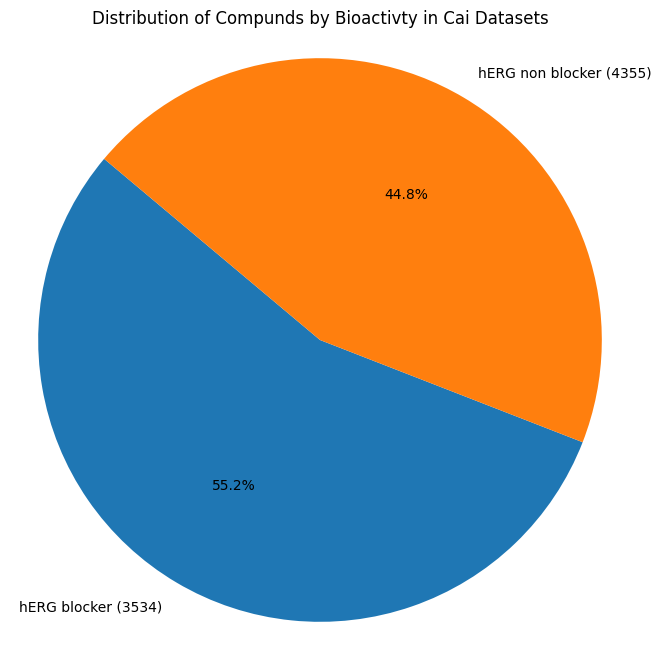

In [44]:
import matplotlib.pyplot as plt

class_counts = Original_data['X10'].value_counts()
class_names = {0: 'hERG non blocker', 1: 'hERG blocker'}

# Create a pie chart
plt.figure(figsize=(8, 8))  
wedges, texts, autotexts = plt.pie(class_counts, labels=class_counts.index.map(class_names), autopct='%1.1f%%', startangle=140)

# Add count values next to labels
for i, label in enumerate(texts):
    label.set_text(f"{label.get_text()} ({class_counts[i]})")

plt.title('Distribution of Compunds by Bioactivty in Cai Datasets')  
plt.axis('equal')  
plt.show()

***This figure above shows the distribution of the Compund bioactive state with IC50 values = 10 μM on the cai dataset, which was used to train the DPMN-hERG Model, we can observe the number of positive class and negative class and from this we can deduce that the datasets is relatively balanced.***

***I observed that the Model that was implemented on Ersilia is different from DPMN-hERG that was trained with the Datasets above, the Model that was implemented was trained on a datsets of 393 molecules and is available [here](https://github.com/AI-amateur/DMPNN-hERG/blob/main/example_notebook/I_train.csv) and the test datasets is available [here](https://github.com/AI-amateur/DMPNN-hERG/blob/main/example_notebook/I_test.csv.)***

***So i will be running a prediction on both this model and eos30f3 with the test set to reproduce the same exact value/figure.***

***Predictions were run both on DPMN-hERG Model that was trained on 393 molecules and eos30f3 Model that was implemented on Ersilia, the prediction result for both model was saved in data/Model_predictions***

In [29]:
DPMN_hERG_predictions = pd.read_csv(os.path.join(DATAPATH, "Model_predictions", "chem_preds.csv"))

eos30f3_hERG_predictions = pd.read_csv(os.path.join(DATAPATH, "Model_predictions", "eos30f3_output.csv"))

test_data = pd.read_csv(input_file_path_1, delimiter=',')

In [22]:
DPMN_hERG_predictions.head()

,smiles,X10,X20,X40,X60,X80,X100
0,COCCCn1cc(c2c1cccc2Br)CN(C(=O)C1CNCCC1c1ccn(c(...,0.396678,0.609791,0.881613,0.936048,0.968838,0.977502
1,c1ccc(cc1)CCN1CCC(CC1)c1c([nH]c2c1cccc2)c1ccccc1,0.995796,0.999349,0.999920,0.999985,0.999991,0.999989
2,O=C1N(CCN1c1cccc(c1)C(C)C)CCN1Cc2c(C1)cccc2,0.930222,0.984431,0.998692,0.999661,0.999904,0.999929
3,O=C(NC(c1ccccc1)Cn1nc(cc1C)C)NC1CCN(CC1)Cc1ccn...,0.696081,0.859890,0.990711,0.998634,0.999096,0.999295
4,FC([C@@H](CC[C@]1(C=C(CN1C(=O)N(C)C)c1cc(F)ccc...,0.061834,0.122263,0.316058,0.445192,0.553485,0.657608


In [10]:
eos30f3_hERG_predictions.head()

,key,input,activity
0,PVHUJELLJLJGLN-MRXNPFEDSA-N,C=1([C@@H](C(=C(C)NC1C)C(OC)=O)c1cc(ccc1)[N+](...,0.148929
1,KRMDCWKBEZIMAB-UHFFFAOYSA-N,C1(\c2c(CCc3c1cccc3)cccc2)=C\CCN(C)C,0.873658
2,IYIKLHRQXLHMJQ-UHFFFAOYSA-N,c1(c2c(cccc2)oc1CCCC)C(c1cc(c(OCCN(CC)CC)c(c1)...,0.853444
3,JCGAMUKFIGRQFG-BMRFCAOMSA-N,[H][C@H]1CC[C@@H](C#N)C1C(=O)C3CN(C(C)c2ccc(C#...,0.772669
4,FHBHXTHCXKMLDG-UHFFFAOYSA-N,[nH]1ccnc1-c2ccc(cc2)OCCCN3CCCCC3,0.899602


***Calculating the AUC score and plotting the ROC curve for DPMN-hERG model***

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Calculating  ROC curve and AUC
fpr, tpr, thresholds = roc_curve(merged_test_set['X10'], DPMN_hERG_predictions['X10'])
auc = roc_auc_score(Original_data['X10'], DPMN_hERG_predictions['X10'])

# Calculating bootstrapped AUC values
n_bootstraps = 2000
auc_values = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    indices = np.random.choice(len(Original_data['X10']), len(Original_data['X10']), replace=True)
    auc_values[i] = roc_auc_score(Original_data['X10'].iloc[indices], DPMN_hERG_predictions['X10'].iloc[indices])

# Compute standard error
auc_std_error = np.std(auc_values)
print(f"AUC = {auc:.3f} ± {auc_std_error:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f} ± {auc_std_error:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [7889, 789]

***Calculating the auc score and plotting the ROC curve for eos30f3 model***

AUC = 0.793 ± 0.037


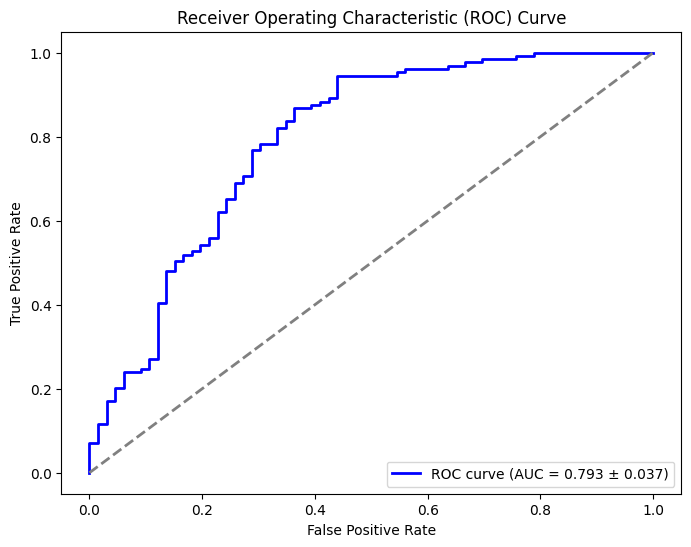

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_data['class'], eos30f3_hERG_predictions['activity'])
auc = roc_auc_score(test_data['class'], eos30f3_hERG_predictions['activity'])

# Calculate bootstrapped AUC values
n_bootstraps = 1000
auc_values = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    indices = np.random.choice(len(test_data['class']), len(test_data['class']), replace=True)
    auc_values[i] = roc_auc_score(test_data['class'].iloc[indices], eos30f3_hERG_predictions['activity'].iloc[indices])

# Compute standard error
auc_std_error = np.std(auc_values)

# Print AUC with ± standard error
print(f"AUC = {auc:.3f} ± {auc_std_error:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f} ± {auc_std_error:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [43]:
import math
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score


y_true = test_data['class']

y_pred = eos30f3_hERG_predictions['activity']

threshold = 0.5

y_pred_binary = (y_pred >= threshold).astype(int)
# Calculating  evaluation metrics
cm = confusion_matrix(y_true, y_pred_binary)
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
roc_auc = roc_auc_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
mcc = matthews_corrcoef(y_true, y_pred_binary)
cohen_kappa = cohen_kappa_score(y_true, y_pred_binary)

# Creating a PrettyTable
table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["Accuracy", accuracy])
table.add_row(["Precision", precision])
table.add_row(["Recall", recall])
table.add_row(["F1 Score", f1])
table.add_row(["ROC AUC", roc_auc])
table.add_row(["Balanced Accuracy", balanced_accuracy])
table.add_row(["MCC", mcc])
table.add_row(["Cohen's Kappa", cohen_kappa])
print(table)



+-------------------+--------------------+
|       Metric      |       Value        |
+-------------------+--------------------+
|      Accuracy     | 0.7897435897435897 |
|     Precision     | 0.8013698630136986 |
|       Recall      | 0.9069767441860465 |
|      F1 Score     | 0.850909090909091  |
|      ROC AUC      | 0.7929292929292929 |
| Balanced Accuracy | 0.7337914023960534 |
|        MCC        | 0.5100947888195358 |
|   Cohen's Kappa   | 0.4989659710471893 |
+-------------------+--------------------+
